# Лабораторная работа №4.Самоорганизующиеся карты Кохонена (SOM).


## Цель работы
Изучить принципы работы самоорганизующихся карт Кохонена (SOM),
реализовать модель и провести эксперименты на данных.

## Задачи
1. Ознакомиться с принципами работы SOM.  
2. Выбрать датасет по варианту.
3. Подготовить датасет, включая предобработку.
4. Реализовать самоорганизующуюся карту Кохонена размером 10x10.
5. Обучить SOM на выбранном датасете, настроив гиперпараметры (размер шага, радиус соседства).
6. Визуализировать результаты в виде топографической карты и цветовой карты кластеров.
7. Сравнить кластеры SOM с известными метками классов (если имеются) и оценить качество кластеризации.
8. Составить отчет с анализом результатов и выводами.


## Индивидуальное задание
Вариант 3: Кластеризация данных о потреблении алкоголя в России  
Датасет: "Alcohol Consumption in Russia" (содержит данные о потреблении алкоголя по регионам России).
Задачи:
- Определить регионы с похожими паттернами потребления алкоголя.
- Выявить возможные зависимости между потреблением алкоголя и социально-экономическими характеристиками регионов.
- Сравнить результаты с K-Means кластеризацией.



## Ход выполнения работы

Производился импорт необходимых библиотек и самого датасета согласно варианту.

In [ ]:
# Импорт библиотек
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from minisom import MiniSom
from sklearn.metrics import silhouette_score

# Загрузка и просмотр датасета
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/russia_alcohol.csv")

df.head(5)

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


Загружается датасет Alcohol Consumption in Russia, который содержит 1615 записей с информацией о продажах алкогольной продукции в регионах РФ.

Была получена информация по столбцам датасета и произведена проверка на пропуски в записях. Пропуски были заполнены средними значениями между данными.


In [ ]:
# Проверка значений
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1615 non-null   int64  
 1   region     1615 non-null   object 
 2   wine       1552 non-null   float64
 3   beer       1557 non-null   float64
 4   vodka      1554 non-null   float64
 5   champagne  1552 non-null   float64
 6   brandy     1549 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 88.4+ KB


,0
year,0
region,0
wine,63
beer,58
vodka,61
champagne,63
brandy,66


In [ ]:
# Обработка пропущенных значений
df_colums = ["wine", "beer", "vodka", "champagne", "brandy"]
df[df_colums] = df[df_colums].fillna(df[df_colums].mean())

df.isna().sum()

,0
year,0
region,0
wine,0
beer,0
vodka,0
champagne,0
brandy,0


Была произведена группировка данных по регионам с помощью метода groupby(). Бралось среднее значение по региону.

In [ ]:
# Группировка по регионам
df_group = df.groupby("region")[df_colums].mean()

df_group.head(5)

,wine,beer,vodka,champagne,brandy
region,,,,,
Altai Krai,3.174211,48.373158,9.465789,1.207368,0.236842
Altai Republic,5.190000,36.724211,9.683684,0.934737,0.253684
Amur Oblast,5.221579,53.377368,14.216842,1.115789,0.396842
Arkhangelsk Oblast,8.670000,47.036842,17.381053,1.631053,0.870526
Astrakhan Oblast,4.469474,54.695263,9.296842,0.861579,0.361053


Данные были нормализованы с помощью MinMaxScaler. Это необходимо для корректной работы алгоритмов, особенно для K-Means, который чувствителен к масштабу данных.

In [ ]:
# Нормализация
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_group[df_colums])

#df_scaled

Модель самоорганизующиеся карты Кохонена была реализована с помощью библиотеки MiniSom. В методе обучения указывались следующие параметры: размеры карты, длина данных, радиус соседства, размер шага, случайное начальное число.

Производилось обучение модели с количеством итераций равном 1000 методом train() и параметром verbose равным True для отслеживания хода обучения.

In [ ]:
# Инициализация SOM
n = 10

model = MiniSom(x=n,
                y=n,
                input_len=len(df_colums),
                sigma=2,
                learning_rate=16,
                random_seed=0)

# Обучение SOM
model.train(df_scaled, num_iteration=1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.25436030567979556


После обучения была реализована топографическая карта для отслеживания результатов активации нейронов на карте.

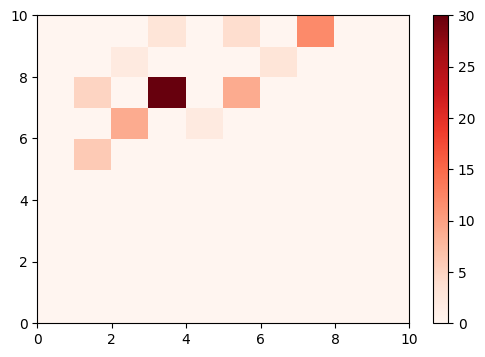

In [ ]:
# Топографическая карта
df_scaled = pd.DataFrame(df_scaled, columns=df_group.columns, index=df_group.index)

plt.figure(figsize=(6, 4))
frequencies = model.activation_response(df_scaled.values)
plt.pcolor(frequencies.T, cmap='Reds')
plt.colorbar()
plt.show()

Производилась визуализация тепловой карты данных до кластеризации.

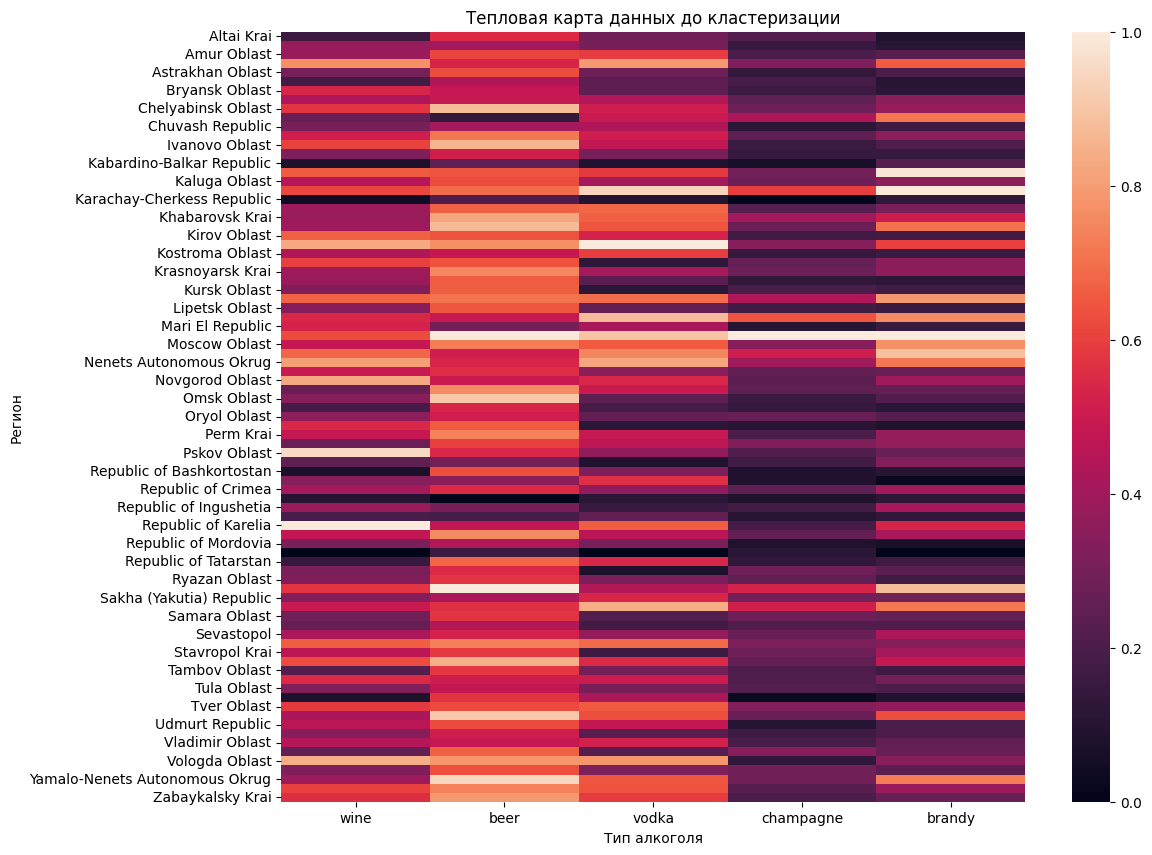

In [ ]:
# Визуализация тепловой карты данных до кластеризации
plt.figure(figsize=(12, 10))
sns.heatmap(df_scaled)
plt.title("Тепловая карта данных до кластеризации")
plt.xlabel("Тип алкоголя")
plt.ylabel("Регион")

plt.show()

Производилась визуализация тепловой карты данных после кластеризации. Для этого были получены координаты нейронов победителей, каждому из которых был присвоен свой номер кластера.

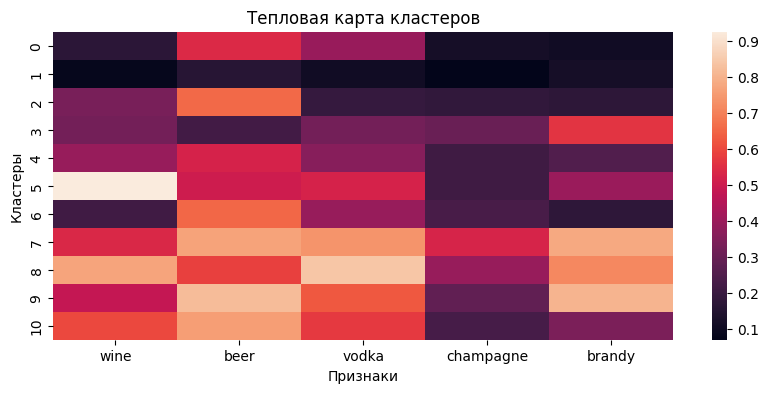

In [ ]:
# Визуализация тепловой карты данных после кластеризации
n_winners = [tuple(model.winner(x)) for x in df_scaled.values]
n_unique = {x: i for i, x in enumerate(sorted(set(n_winners)))}

cluster_labels = [n_unique[x] for x in n_winners]

df_clusters = df_scaled.copy()
df_clusters["cluster"] = cluster_labels

heatmap = df_clusters.groupby("cluster").mean()

plt.figure(figsize=(10, 4))
sns.heatmap(heatmap)
plt.title("Тепловая карта кластеров")
plt.xlabel("Признаки")
plt.ylabel("Кластеры")

plt.show()

Для сравнения и поиска регионов по номерам кластеров был реализован отдельный датафрейм с возможностью поиска по конкретному значению номера кластера.

In [ ]:
#(df_clusters["cluster"].value_counts(),
#len(df_clusters["cluster"].value_counts()),

df_clusters.sort_values(by="cluster", ascending=True)

,wine,beer,vodka,champagne,brandy,cluster
region,,,,,,
Belgorod Oblast,0.176704,0.430744,0.240497,0.185195,0.103578,0
Republic of Bashkortostan,0.072479,0.631221,0.318057,0.085156,0.104520,0
Republic of Tatarstan,0.145833,0.676663,0.541252,0.130581,0.166196,0
Republic of Buryatia,0.336660,0.350131,0.562930,0.084121,0.028719,0
Tuva Republic,0.076097,0.570583,0.424811,0.031060,0.085217,0
...,...,...,...,...,...,...
Tver Oblast,0.586893,0.619167,0.654052,0.328459,0.364878,10
Sverdlovsk Oblast,0.625292,0.844273,0.550003,0.255986,0.491525,10
Vologda Oblast,0.841036,0.784671,0.781916,0.132263,0.338041,10


In [ ]:
df_clusters.loc[df_clusters["cluster"] == 1]

,wine,beer,vodka,champagne,brandy,cluster
region,,,,,,
Kabardino-Balkar Republic,0.075514,0.249681,0.088950,0.061861,0.232109,1
Karachay-Cherkess Republic,0.041667,0.203639,0.097602,0.000000,0.121469,1
Republic of Dagestan,0.098915,0.000000,0.115338,0.079073,0.118173,1
Republic of Kalmykia,0.191702,0.186720,0.251921,0.104310,0.125235,1
Republic of North Ossetia-Alania,0.000000,0.160480,0.000000,0.110133,0.000000,1


Аналогичным образом была построена тепловая карта на основе обучения модели методом K-Means.

In [ ]:
# Проверка методом Kmeans
kmeans = KMeans(n_clusters=11, random_state=0)
kmeans_labels = kmeans.fit_predict(df_scaled.values)

df_kmeans = df_scaled.copy()
df_kmeans["cluster"] = kmeans_labels

kmeans_summary = df_kmeans.groupby("cluster").mean()

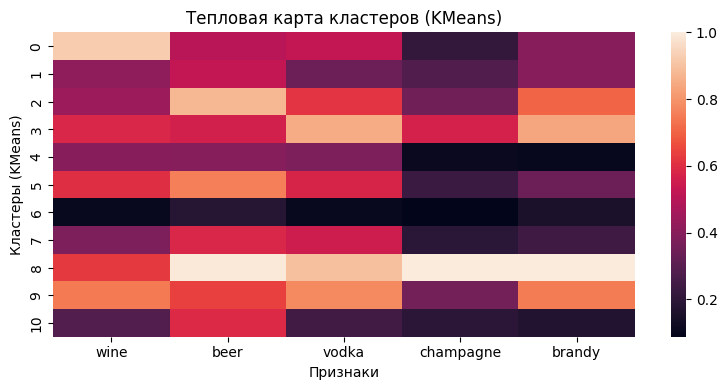

In [ ]:
# Тепловая карта
plt.figure(figsize=(8, 4))
sns.heatmap(kmeans_summary)
plt.title("Тепловая карта кластеров (KMeans)")
plt.xlabel("Признаки")
plt.ylabel("Кластеры (KMeans)")
plt.tight_layout()
plt.show()

In [ ]:
df_kmeans.sort_values(by="cluster", ascending=True)

,wine,beer,vodka,champagne,brandy,cluster
region,,,,,,
Pskov Oblast,0.949638,0.539135,0.365923,0.209913,0.268362,0
Republic of Karelia,1.000000,0.472972,0.663638,0.182477,0.533898,0
Novgorod Oblast,0.825105,0.494313,0.539582,0.241232,0.395480,0
Chechen Republic,0.430758,0.488631,0.439258,0.244343,0.346185,1
Krasnoyarsk Krai,0.394491,0.753454,0.411617,0.276433,0.362053,1
...,...,...,...,...,...,...
Volgograd Oblast,0.253268,0.664596,0.225934,0.341530,0.265537,10
Ulyanovsk Oblast,0.336660,0.515523,0.228272,0.165265,0.201036,10
Tuva Republic,0.076097,0.570583,0.424811,0.031060,0.085217,10


In [ ]:
df_clusters.loc[df_clusters["cluster"] == 1]

,wine,beer,vodka,champagne,brandy,cluster
region,,,,,,
Kabardino-Balkar Republic,0.075514,0.249681,0.088950,0.061861,0.232109,1
Karachay-Cherkess Republic,0.041667,0.203639,0.097602,0.000000,0.121469,1
Republic of Dagestan,0.098915,0.000000,0.115338,0.079073,0.118173,1
Republic of Kalmykia,0.191702,0.186720,0.251921,0.104310,0.125235,1
Republic of North Ossetia-Alania,0.000000,0.160480,0.000000,0.110133,0.000000,1


Результаты были проверены с помощью метрики силуэта.

In [ ]:
som_silhouette = silhouette_score(df_scaled.values, cluster_labels)
kmeans_silhouette = silhouette_score(df_scaled.values, kmeans_labels)

print(f"Метрика силуэта для сети Кохонена: {som_silhouette:.4f}")
print(f"Метрика силуэта для K-Means: {kmeans_silhouette:.4f}\n")

Метрика силуэта для сети Кохонена: 0.1164
Метрика силуэта для K-Means: 0.2443



## Вывод
В ходе лабораторной работы была проведена кластеризация данных о потреблении алкоголя в российских регионах с использованием двух методов: самоорганизующейся карты Кохонена (SOM) и алгоритма KMeans. Цель заключалась в выявлении общих закономерностей между регионами.
На первом этапе был реализован метод SOM. Данные были распределены по нейронам карты размером 10×10, после чего они были сгруппированы по координатам выигравших нейронов. В результате было выделено 11 кластеров. На тепловой карте SOM стали заметны некоторые различия между группами, однако большинство признаков не продемонстрировали чёткого разделения. Это подтвердилось значением метрики силуэта — 0.1164, что указывает на слабую структурированность кластеров и значительное их перекрытие.
Для сравнения применялся алгоритм KMeans с тем же числом кластеров. Его результаты оказались существенно лучше: кластеры получились более компактными, тепловая карта показала более выраженные различия по признакам, а значение метрики силуэта составило 0.2443. Это свидетельствует о более высоком качестве кластеризации — объекты внутри кластеров были ближе друг к другу и дальше от других групп.
Низкое значение метрики силуэта в случае с SOM может объясняться высокой размерностью и разнородностью данных, так как потребление различных видов алкоголя существенно различается по регионам. Кроме того, возможной причиной является неравномерное распределение данных, из-за чего границы между кластерами становятся менее чёткими. Также SOM чувствителен к масштабу признаков, несмотря на предварительную нормализацию.
В итоге можно сделать вывод, что SOM хорошо подходит для визуального анализа и изучения структуры данных, особенно когда важны топологические связи между элементами. Однако в данной задаче метод KMeans показал себя более эффективным с точки зрения качества кластеризации и чёткости разделения. Он оказался проще в применении и лучше справился с выделением явно выраженных групп. В целом, SOM может быть полезен на этапе предварительного анализа, тогда как KMeans предпочтительнее при необходимости точного и интерпретируемого разделения данных.
